In [1]:
import networkx as nx
import pandas as pd
from neo4j import GraphDatabase
# Change the host and user/password combination to your neo4j
host = 'bolt://3.239.224.171:7687'
user = 'neo4j'
password = 'rainbow-mittens-track'
driver = GraphDatabase.driver(host,auth=(user, password))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Example input to NetworkX
```
lines = ["1 2 {'weight': 3}", "2 3 {'weight': 27}", "3 4 {'weight': 3.0}"]
G = nx.parse_edgelist(lines, nodetype=int)
```

Node ids have to be consecutive for karateclub to work!!!

## Define consecutive id mapping in Neo4j

In [99]:
read_query("""
MATCH (c:Character)
WHERE (c)-[:INTERACTS]-()
WITH count(*) as number, collect(c) as nodes
UNWIND range(0, number - 1) as index
WITH nodes[index] as node, index
SET node.index = index
RETURN distinct 'done'
""")

,'done'
0,done


# Fetch edge list from neo4j

In [106]:
edge_list = read_query("""
MATCH (s:Character)-[r:INTERACTS]->(t:Character)
WITH toString(s.index) + " " + toString(t.index) + " {'weight':" + toString(r.weight)  + "}" as edge
WITH collect(edge) as result
RETURN result
""")
edge_list = edge_list['result'].to_list()[0]

# Create graph

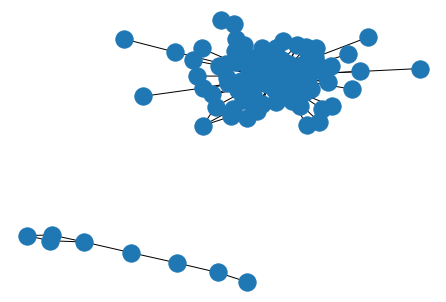

In [107]:
G = nx.parse_edgelist(edge_list, create_using=nx.Graph(), nodetype=int)

nx.draw(G)

# Run Role2vec

In [108]:
from karateclub.node_embedding.structural import GraphWave, Role2Vec

roleModel = Role2Vec(walk_length=20)

roleModel.fit(G)

roleEmbeddings = roleModel.get_embedding()

# Fetch character mapping

In [109]:
character_mapping = read_query("""
MATCH (c:Character)
WHERE ((c)-[:INTERACTS]-())
RETURN c.name as character, c.index as index
ORDER BY index
""")

In [91]:
results = []
for name,embedding in zip(character_mapping['character'].to_list(), roleEmbeddings):
    results.append({'character': name, 'embedding': embedding})
    
df = pd.DataFrame.from_dict(results)

In [110]:
df.head()

,character,embedding,tsne_x,tsne_y
0,Vernon Dursley,"[11, 4, 3, 90, 99, 8, 11, 5, 10, 98, 11, 4, 9,...",25.299618,1.952974
1,Petunia Dursley,"[11, 4, 3, 5, 99, 8, 11, 5, 10, 98, 11, 4, 9, ...",22.172237,5.207416
2,Dudley Dursley,"[11, 12, 3, 5, 99, 8, 11, 5, 10, 98, 11, 4, 9,...",42.545429,39.391914
3,Lily J. Potter,"[11, 12, 45, 5, 99, 8, 45, 5, 10, 98, 11, 4, 9...",18.558056,-0.510532
4,James Potter I,"[11, 12, 3, 5, 99, 8, 14, 5, 10, 98, 11, 4, 9,...",20.294390,-5.132749


# Draw a TSNE

In [93]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette=sns.color_palette("hls", 10),
        data=embeddings,
        legend="full",
        alpha=0.9
    )
    
    for i in range(df.shape[0]):
        plt.text(x=df['tsne_x'][i]+0.3,y=df['tsne_y'][i]+0.3,s=df.character[i], 
              fontdict=dict(color='black',size=10),)

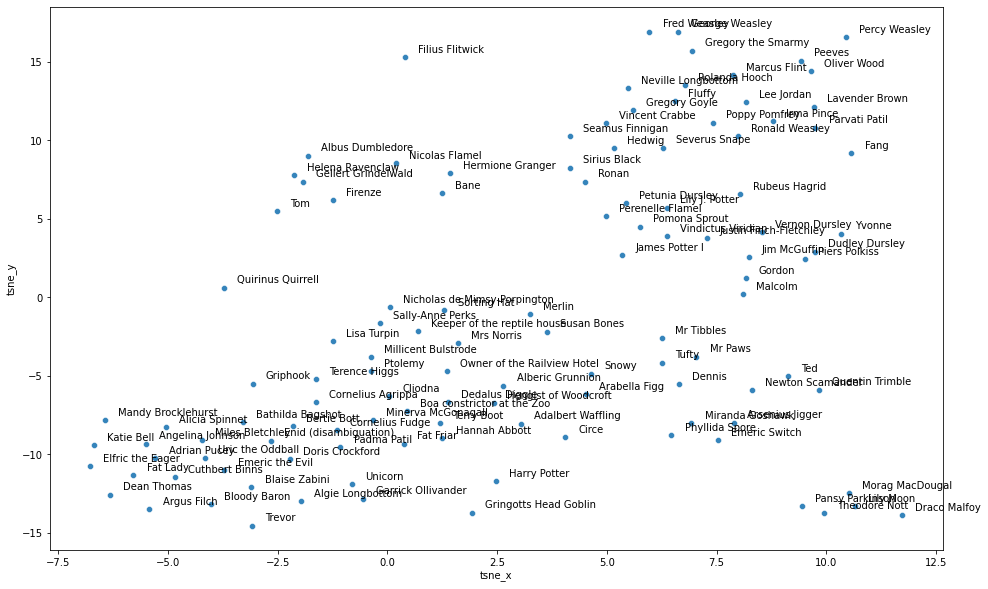

In [94]:
tsne(df)

In [95]:
from karateclub.node_embedding.neighbourhood import NodeSketch


model = NodeSketch()

model.fit(g)

embeddings = model.get_embedding()


In [96]:
results = []
for name,embedding in zip(character_mapping['character'].to_list(), embeddings):
    results.append({'character': name, 'embedding': embedding})
    
df = pd.DataFrame.from_dict(results)

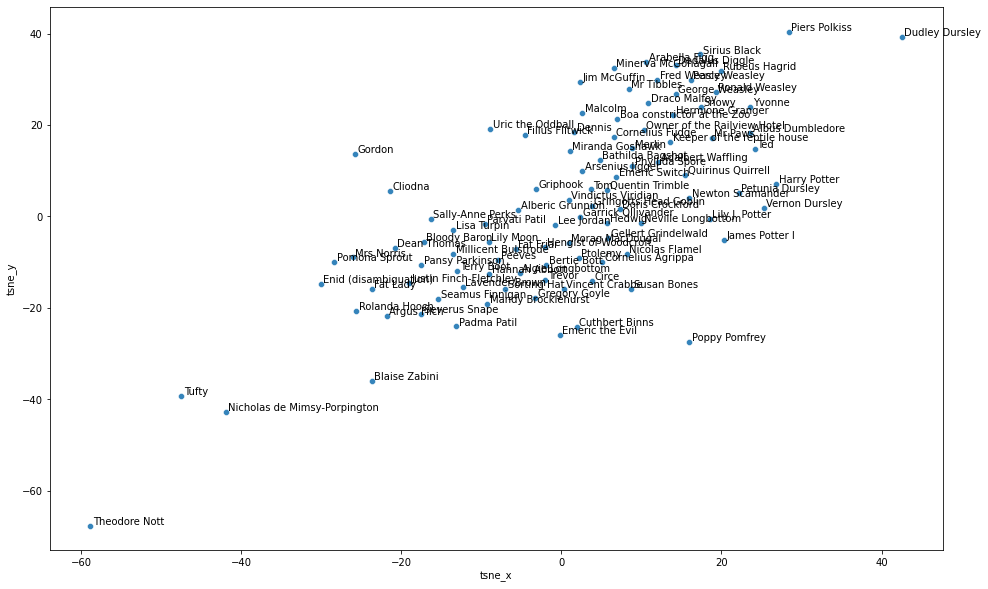

In [97]:
tsne(df)